# Deep Learning for Image Classification

In this notebook we will be implementing an image classifier using a deep learning framework.

The dataset we will be using is the Fashion MNIST dataset.

According to the [TensorFlow docs](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data), this is a dataset of 60,000 28x28 grayscale images of 10 fashion categories, along with a test set of 10,000 images. 

The classes are:

| Label | Description |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

## Preamble

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow and Keras libraries
import tensorflow as tf
from tensorflow.keras import datasets, Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

# Keras Tuner library
import keras_tuner as kt

# Scikit-learn libraries
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, precision_score, recall_score, f1_score

2024-08-06 16:01:23.504845: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Part 1: Explore Data

In [2]:
# load data
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()
print(f'Training data set shape: {x_train.shape}')
print(f'Training labels shape: {y_train.shape}')
print(f'Testing set shape: {x_test.shape}')
print(f'Testing labels shape: {y_test.shape}')

Training data set shape: (60000, 28, 28)
Training labels shape: (60000,)
Testing set shape: (10000, 28, 28)
Testing labels shape: (10000,)


In [3]:
# create list of class names in the order of their labels
class_names = ['T-shirt/top',
               'Trouser',
               'Pullover',
               'Dress',
               'Coat', 
               'Sandal',
               'Shirt',
               'Sneaker',
               'Bag',
               'Ankle boot']

In [4]:
# look at the first item in the training dataset
print(x_train[0])
print()
print(f"Shape of item at index 0: {x_train[0].shape}")

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0
    0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62
   54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134
  144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178
  107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216
  216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1   1   0 200 232 23

The images have a shape of 28 by 28 pixels, each containing a number that ranges from 0 to 255.

Next, we'll visualize them.

In [5]:
# helper function to display individual image
def show_indiv_image(df, idx, label_idx, cmap=None):
    plt.figure(figsize=(4,4))
    plt.imshow(df[idx], cmap=cmap)
    plt.colorbar()
    plt.grid(False)
    plt.title(f'Image Label: {class_names[label_idx]}')
    plt.show()

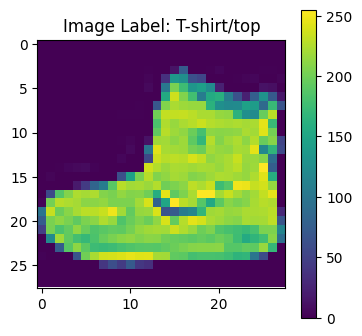

In [6]:
show_indiv_image(x_train, 0, 0)

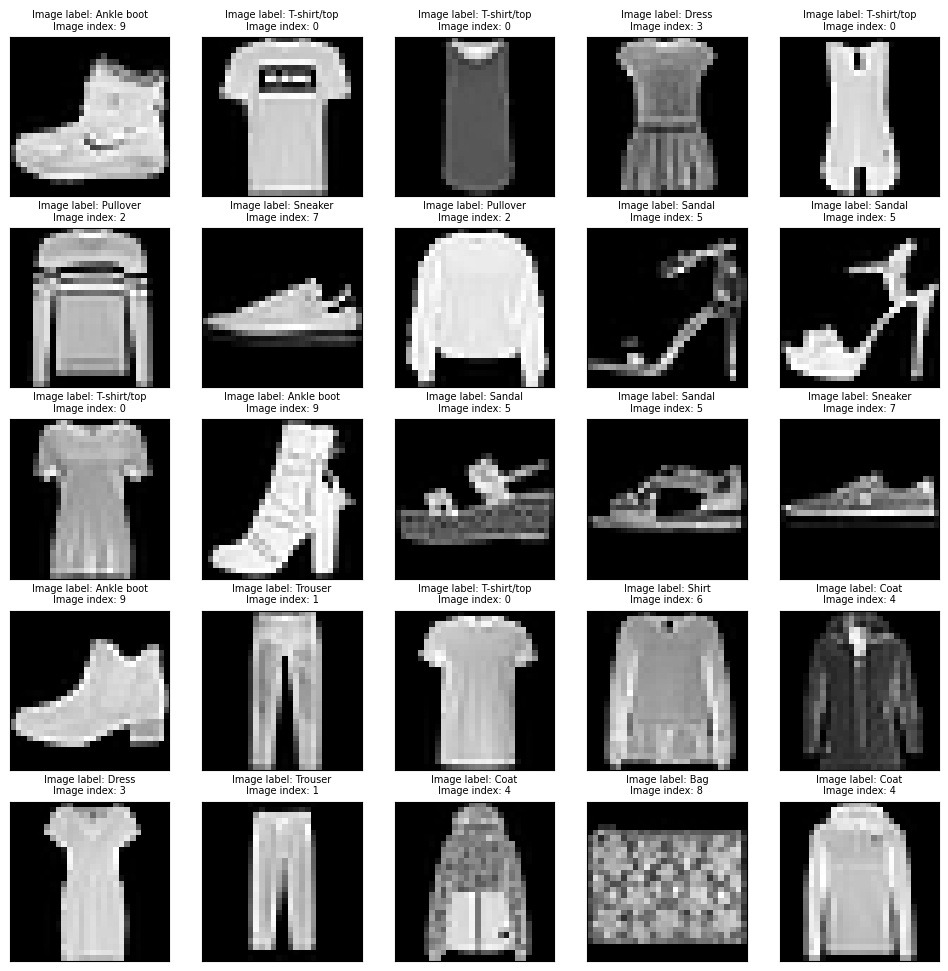

array([9, 0, 0, 3, 0], dtype=uint8)

In [7]:
# visualize the first 25 fashion pieces in grayscale
plt.figure(figsize=(12,12))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"Image label: {class_names[y_train[i]]}\nImage index: {y_train[i]}", fontsize=7)
plt.show()

y_train[:5]

Looking at the first 5 items (top row) in the `y_train` dataset which stores the target variable, we see that they are correspond to the images:
1. Shoe
2. Top
3. Top 
4. Dress
5. Top

Finally, we conclude this section with the number of value counts for each label:

In [8]:
print(f'Training set labels:\n{pd.Series(y_train).value_counts()}')
print()
print(f'Test set labels:\n{pd.Series(y_test).value_counts()}')

Training set labels:
9    6000
0    6000
3    6000
2    6000
7    6000
5    6000
1    6000
6    6000
4    6000
8    6000
Name: count, dtype: int64

Test set labels:
9    1000
2    1000
1    1000
6    1000
4    1000
5    1000
7    1000
3    1000
8    1000
0    1000
Name: count, dtype: int64


The number of labels are evenly distributed in both the training and test sets. Each of the 10 unique labels are equally represented - making up 10% of the training and test sets.

## Part 2: Preprocessing

Because we'll be training a neural network for our image classifier, we'll need to normalize the image data so that it ranges within 0 to 1.

We can do this by dividing the pixels by the maximum number in the dataset, 255.

In [9]:
# normalize the data
x_train = x_train / 255.0
x_test = x_test / 255.0

When we display the image of the first item again, everything looks the same other than the color map on the right.

It now ranges from 0 to 1 whereas prior to the normalization, it ranged from 0 to 255.

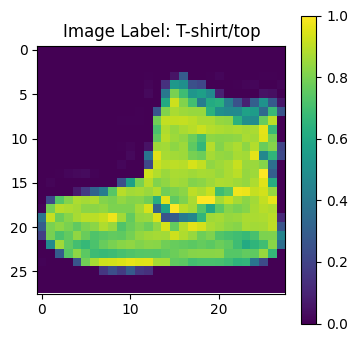

In [10]:
show_indiv_image(x_train, 0, 0)

Lastly, for this section we will apply one-hot encoding to the target variables

In [11]:
print(f"Training set shape for Target variable pre-OHE: {y_train.shape}")
print(f"Training set shape for Target variable pre-OHE: {y_test.shape}")

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(f"Training set shape for Target variable post-OHE: {y_train.shape}")
print(f"Training set shape for Target variable post-OHE: {y_test.shape}")

Training set shape for Target variable pre-OHE: (60000,)
Training set shape for Target variable pre-OHE: (10000,)
Training set shape for Target variable post-OHE: (60000, 10)
Training set shape for Target variable post-OHE: (10000, 10)


In [12]:
y_train[:5]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

## Part 3: Build the Model

In [13]:
num_classes = y_train.shape[1]

In [14]:
# set random seeds
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

We'll split the training set into two sets: one for training (80% of the training dataset) and one for validation (remaining 20%).

Our model will firstly be trained on the training set and secondly be validated with the validation set. The purpose of this additional step is to avoid overfitting.

Finally, we'll pass the test data into the trained model for evaluation.

In [15]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

We initate our neural network model by calling `Sequential()` to store our linear stack of layers.

We then proceed to build the network architecture using the following 12 layers:
1. `Conv2D`: this is a 2D convolutional layer with 64 filters each with a kernel size of 3 x 3
    - each of the 64 filters (or kernels) will slide over each input image, computing a dot product between the kernel and the input at each position.
    - as a result, we get 64 feature maps that the ReLU activation function will be applied to, resulting in the negative values (in the feature maps) being set to 0.
    - these 64 feature maps are combined into a single 3D tensor which will be fed to the next layer
2. `BatchNormalization`: normalizes and scales the 3D tensor from the previous layer
    - the output tensor from this layer is then fed into the next layer, while maintaining the same shape but with normalized values
    - this layer stablizes and accelerates training
3. `MaxPooling2D`: reduces the spatial dimensions of the feature maps inputted to this layer
    - this layer performs down-sampling while retaining the most important information.
    - by taking the maximum value over a 2x2 window for each feautre map, the output of this layer is effectively reduced by a factor of 2.
4. `Conv2D`: this is a 2D convolutional layer with 128 filters each with a kernel size of 3 x 3
    - applies 128 new filters to the feature maps produced by the previous layer
    - since this convolutional layer is deeper in the network, it would be combining the lower-level feaures (that were detected by initial layers of the CNN closer to the input) to form more complex patterns.
    - this results in a new set of 128 features maps that are more abstract and high-level.
5. `BatchNormalization`: normalizes and scales the 3D tensor from the previous layer
6. `MaxPooling2D`: reduces the spatial dimensions of the feature maps inputted to this layer
7. `Dropout`: randomly drops a proportion of the input units to 0
    - helps to prevent overfitting by ensuring that the model does not rely too much on an individual neuron
8. `Flatten`: flattens the 2D feature maps from the previous layer into a 1D vector
    - this layer is necessary to transition from convolutionaly layers to fully connected layers
9. `Dense`: a fully connected (dense) layer with ReLU activation
    - each neuron in this layer receives input from all the neurons of the previous layer, allowing the network to lean complex representations
10. `BatchNormalization`: normalizes and scales the 1D tensor from the previous layer
11. `Dropout`: randomly drops a proportion of the input units to 0
12. `Dense`: the final fully connected layer
    - number of neurons is equal to the number of classes, using softmax activation
    - the softmax activation function converts the output into a probability distribution over the classes
    - each neuron output represents the probabilty of the input belonging to a specific class.
    - output shape = (10,)

In [ ]:
def build_model(hp):
    model = Sequential()
    
    model.add(Conv2D(64, (3, 3), input_shape=(28, 28, 1), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Flatten())
    
    model.add(Dense(units=hp.Int('dense_units', min_value=256, max_value=512, step=64), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    # Tuning the learning rate
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

We'll be doing a 4-fold cross-validation on our model to lower the risk of overfitting.

Furthermore, we will be tuning our hyperparameter using Keras Tuner.

According to [Keras's Github repo](https://github.com/keras-team/keras-tuner/blob/v1.4.7/keras_tuner/engine/tuner.py), we could define a custom tuner by subclassing the `RandomSearch` class of the Keras Tuner API. The tuner we're customizing will override the `run_trial` method to implement cross-validation during the hyperparameter tuning process. Additionally, the tuner will inherit the random search strategy from `RandomSearch` while allowing us to define how each trial will be evaluated.

The hyperparameters and the possible values to be tuned:
- Layer 7 `Dropout` - proportion of data to drop off: `0.2`, `0.3`, `0.4`, `0.5`
- Layer 9 `Dense` - number of neurons: `256`, `320`, `384`, `448`, `512`
- Layer 11 `Dropout` - proportion of data to drop off: `0.2`, `0.3`, `0.4`, `0.5`
- `learning_rate` - ranges from 0.0001 to 0.01; value will beinputted into the `Adam` optimizer

Due to compute limitations, we will be setting the number of `epochs` to 10 and the `max_trials` to 3. This means that the tuner will evaluate 3 different combinations of hyperparameters. For each combination, it will perform 4-fold cross-validation on the `x_train` dataset, with each fold being trained for 10 epochs.

In total, this will result in 12 model trainings (3 trials * 4 folds), each running for 10 epochs, for a total of 120 epoch trainings across the entire tuning process.

In [ ]:
# Define the K-Fold cross-validator
num_folds = 4
kfold = KFold(n_splits=num_folds,
              shuffle=True,
              random_state=42)

# Custom Tuner class with cross-validation
class CVTuner(kt.RandomSearch):
    def run_trial(self, trial, x, y, **kwargs):
        val_scores = []
        for train, val in kfold.split(x, y):
            model = self.hypermodel.build(trial.hyperparameters)
            # early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
            model.fit(x[train], y[train],
                      epochs=10,
                      validation_data=(x[val], y[val]),
                      verbose=2)
            val_scores.append(model.evaluate(x[val], y[val], verbose=2)[1])  # Get accuracy
        return np.mean(val_scores)

# Create and run the tuner
tuner = CVTuner(build_model,
                objective='val_accuracy',
                max_trials=3,
                executions_per_trial=1,
                directory='my_dir',
                project_name='fashion_mnist_tuning_cv')

tuner.search(x_train, y_train, verbose=2)

Each of the 3 trials will be saved in the `my_dir` project folder.

In [ ]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
best_model = build_model(best_hps)

print("Best hyperparameters:")
for param in best_hps.values:
    print(f"{param}: {best_hps.get(param)}")

Now that we have trained our model using the training data, we get an accuracy score of 90.7%.

During the hyperparameter tuning process, the following parameters had the best performance:
- Layer 7 `Dropout` - proportion of data to drop off: `0.4`
- Layer 9 `Dense` - number of neurons: `320`
- Layer 11 `Dropout` - proportion of data to drop off: `0.4`
- `learning_rate` - 0.000263474572751995

We'll now run the model on the validation data.

In [19]:
# Train the final model on the validation set
# early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
final_history = best_model.fit(x_train, y_train,
                               validation_data=(x_val, y_val),
                               epochs=20,
                               batch_size=200,
                               verbose=2)

Epoch 1/50


ValueError: Unknown variable: <KerasVariable shape=(3, 3, 1, 64), dtype=float32, path=sequential_13/conv2d_26/kernel>. This optimizer can only be called for the variables it was originally built with. When working with a new set of variables, you should recreate a new optimizer instance.

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(final_history.history['accuracy'], label='Train Accuracy')
plt.plot(final_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xlim(0,20)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(final_history.history['loss'], label='Train Loss')
plt.plot(final_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim(0,20)
plt.legend()
plt.show()

Although we only used 20 epochs, we can see that the accuracy gains on the validation set have plateaued at around the 91%-92% range.

We note that, however, the accuracy on the training set was still increasing at the 20th epoch, but this is probably due to overfitting given the yawning divergence against the validation set's accuracy.

Before we apply the model on the test set, let's take a look at our neural network's layers and their corresponding output shapes and parameters:

In [18]:
best_model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_26 (Conv2D)              │ (None, 26, 26, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 26, 26, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 11, 11, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 320)            │     1,024,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 320)            │         1,280 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 10)             │         3,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,104,076 (4.21 MB)

 Trainable params: 1,103,050 (4.21 MB)

 Non-trainable params: 1,024 (4.00 KB)

 Optimizer params: 2 (12.00 B)

In [20]:
# Evaluate on the test set
test_scores = best_model.evaluate(x_test, y_test, verbose=2)
print(f"Final test accuracy: {test_scores[1]*100:.2f}%")

313/313 - 4s - 13ms/step - accuracy: 0.9160 - loss: 0.2449
Final test accuracy: 91.60%


After running the model on our test set, we get a final score of 91.6%. This figure is comparable to the range when the model was ran on the validation data, thus indicating low evidence of overfitting.

In [17]:
## save model
# best_model.save('best_model.h5')
# best_model.save('best_model.keras')
# best_model = load_model('best_model.h5')

## Part 4: Evaluating the Model

In [21]:
# Predict probabilities
y_pred_proba = best_model.predict(x_test)

# Convert to class labels
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test, axis=1)

# Print classification report
print(classification_report(y_true, y_pred, target_names=class_names))

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
              precision    recall  f1-score   support

 T-shirt/top       0.85      0.88      0.87      1000
     Trouser       1.00      0.98      0.99      1000
    Pullover       0.90      0.85      0.87      1000
       Dress       0.93      0.91      0.92      1000
        Coat       0.81      0.92      0.86      1000
      Sandal       0.99      0.97      0.98      1000
       Shirt       0.78      0.71      0.75      1000
     Sneaker       0.95      0.98      0.96      1000
         Bag       0.98      0.99      0.98      1000
  Ankle boot       0.97      0.96      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



Overall, the model had precision and recall scores of 92%.

Looking at the individual fashion items, the model was not as accurate in classifying clothes relating to the upper body such as `T-shirt/top`, `Pullover`, `Coat`, and `Shirt`. This is understandably so as the shape of these items appear more similar compared to the others. Taking a closer look, the accuracy for `Shirt` was notably lower with it's F1 score being only 75%.


On the other hand, the model performed very well on items such as `Trouser`, `Sandal`, `Bag` and `Ankle Boot` as indicated by their F1 scores registering ≥97%.

The confusion matrix below helps us visualize the number of times the fashion items were correctly classified and which items they were confused for:

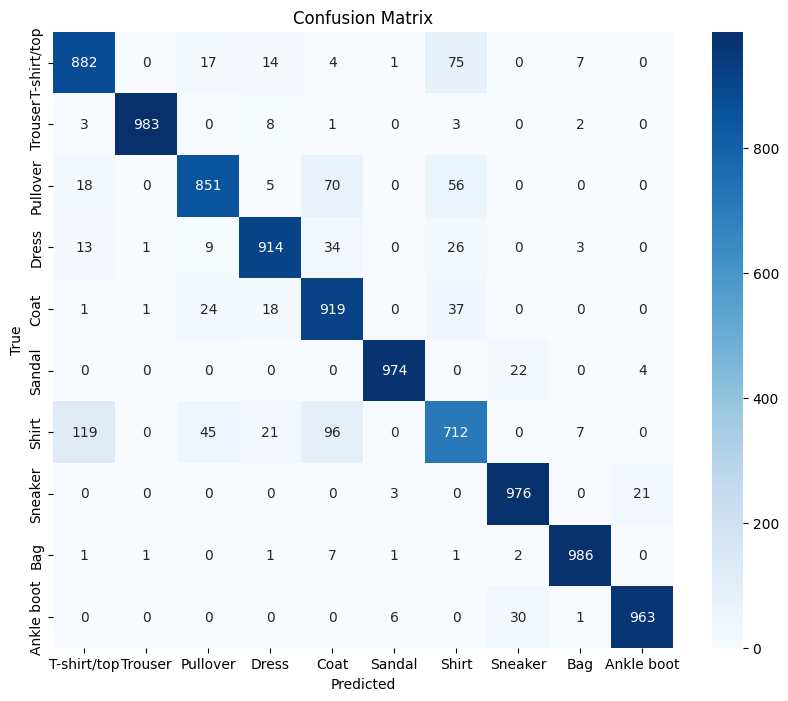

In [22]:
# Analyzing Errors with Confusion Matrix
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

For further evaluation of the model, we will plot the ROC-AUC scores for each of the fashion items:

ROC-AUC Score: 0.9950


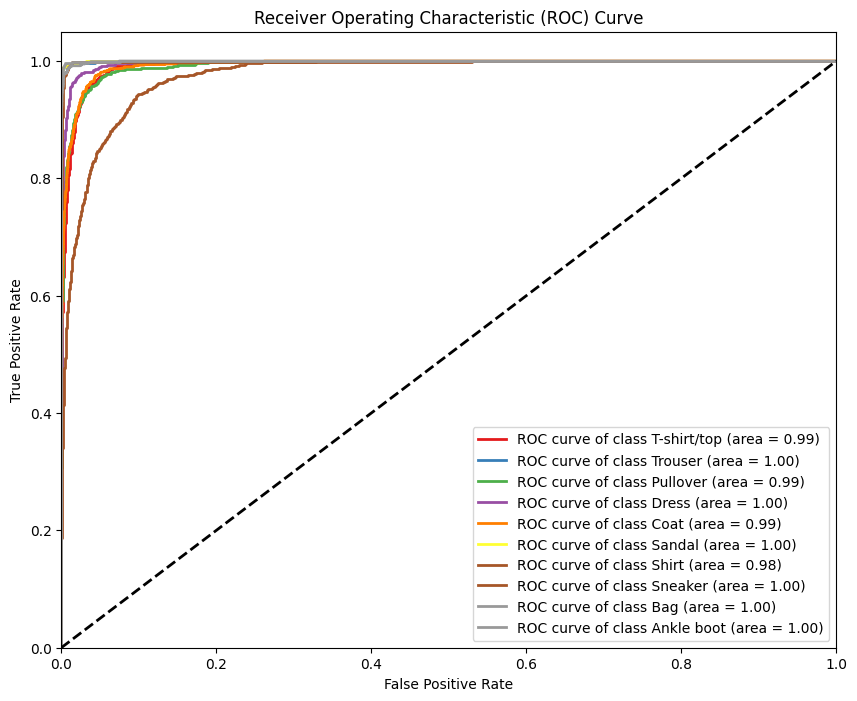

ROC AUC:
{0: 0.9929468888888889, 1: 0.9996322222222223, 2: 0.9927213333333332, 3: 0.9970106666666668, 4: 0.9934665, 5: 0.9997431111111111, 6: 0.9762951111111111, 7: 0.9987952222222222, 8: 0.999815, 9: 0.999373111111111}

Average ROC AUC: 0.9950


In [59]:
# Compute ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Binarize the output for ROC curve
y_test_bin = label_binarize(y_true, classes=np.arange(len(class_names)))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = plt.colormaps.get_cmap('Set1')(np.linspace(0, 1, len(class_names)))
for i, color in zip(range(len(class_names)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print ROC AUC
print(f'ROC AUC:\n{roc_auc}')
print()
print(f"Average ROC AUC: {np.mean(list(roc_auc.values())):.4f}")

The ROC-AUC scores are in line with what we observed from the confusion matrix.

All classes have very high ROC-AUC scores, indicating the model's good performance in distinguishing between positive and negative instances for each class. The lowest scoring class, `Shirt`, had a score of 0.976 while a number of the others had near perfect scores (>0.999) - this suggests that model has performs well across the different labels.

# Conclusion

Our CNN model demonstrated robust performance in classifying the Fashion MNIST dataset, achieving high precision, recall, F1 scores, and ROC-AUC values across all classes.

The 12-layer neural network architecture and thorough hyperparameter tuning significantly contributed to its effectiveness. The evaluation metrics indicate that the model is well-suited for this classification task with minimal overfitting.

Future improvements could focus on enhancing the model's ability to distinguish between similar upper body clothing items.

References
- https://blog.tensorflow.org/2020/01/hyperparameter-tuning-with-keras-tuner.html
- https://www.tensorflow.org/tutorials/keras/keras_tuner
- https://www.tensorflow.org/tutorials/keras/overfit_and_underfit#strategies_to_prevent_overfitting